In [3]:
%load_ext pycodestyle_magic

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from config import db_pw;
import psycopg2;

In [2]:
#establishing the connection
conn = psycopg2.connect(
   database="Predictive_Senescence_DB", user='postgres', password= db_pw, host='predictive-senescence-db.cbunnafql9ym.us-east-2.rds.amazonaws.com', port= '5432'
)

#Setting auto commit false
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Retrieving data
cursor.execute('''SELECT * from birds_data_raw''')

#Fetching 1st row from the table
bird_df = pd.DataFrame(cursor.fetchall(), columns=["Collection_Num", "Bird_ID", "Sex", "Agey", "AgeClass", "BirthFPID", "U_PlateID", "RTL", "Technician", "Terr", "FPID", "Mum", "Dad", "Mac", "Pac", "BRF", "BRM"]);
print(bird_df)

#Commit your changes in the database
conn.commit()

#Closing the connection
conn.close()

      Collection_Num  Bird_ID  Sex       Agey AgeClass  BirthFPID U_PlateID  \
0                  1     5511    0   0.246575        J        103       9_3   
1                  2     5559    1   3.597260        A        103       9_1   
2                  3     5559    1   4.715068        A        103      9_28   
3                  4     5559    1   0.657534       SA        103       9_2   
4                  5     5527    1   0.328767      OFL        103       9_3   
...              ...      ...  ...        ...      ...        ...       ...   
2657            2658      221    1   6.958904        A          8       2_1   
2658            2659      216    1   8.947945        A          8       8_8   
2659            2660      176    1   6.772603        A          8      7_32   
2660            2661      221    1   9.090411        A          8      1_12   
2661            2662      176    1  13.873973        A          8       4_3   

       RTL  Technician   Terr  FPID   Mum   Dad    

In [3]:
max(bird_df["Agey"])

16.9369863

In [4]:
#Make a list to hold unique ID's found in bird_df
passover_list = [0,1]

#Make a DF to hold the overall change in Age and RTL for each bird
changeRate_df = pd.DataFrame(columns=["Bird_ID", "Average_Age", "RTL_Change", "Rate_Of_Change"])

#Iterate once for each row in the bird_df
for i in range(len(bird_df["Bird_ID"])):
    #If the Bird_ID in this row is not in our passover list (already processed), continue
    if(bird_df.loc[i,"Bird_ID"] not in passover_list):

        #Initialize indexer for next row(s) and make a DF to hold all duplicate ID's, their ages and RTL values
        k = i+1
        holder_df = pd.DataFrame({"ID": [bird_df.loc[i,"Bird_ID"]], "Age": [bird_df.loc[i, "Agey"]], "RTL": [bird_df.loc[i,"RTL"]]})

        #Loop through all rows with matching ID's
        while(bird_df.loc[k,"Bird_ID"] == bird_df.loc[i,"Bird_ID"]):
            #Place matching rows data into holder_DF and incriment indexer
            holder_df = holder_df.append({"ID": bird_df.loc[k,"Bird_ID"], "Age": bird_df.loc[k, "Agey"], "RTL": bird_df.loc[k,"RTL"]}, ignore_index=True)
            k = k+1

        #We are only interested in birds with multiple collections -- this is to identify rate of change in telomere
        if(len(holder_df["ID"]) > 1):
            #Initialize variables for changeRate_df populating
            max_age = 0
            min_age = 0
            final_rtl = 0
            first_rtl = 0
            total_ratio = 0
            count = len(holder_df["ID"])
            for row in holder_df.iterrows():
                id = row[1].ID
                if(row[1].Age == max(holder_df["Age"])):
                    max_age = row[1].Age
                    final_rtl = row[1].RTL
                elif(row[1].Age == min(holder_df["Age"])):
                    min_age = row[1].Age
                    first_rtl = row[1].RTL
                total_ratio = total_ratio + (row[1].Age / row[1].RTL)
            Average_Age = holder_df["Age"].mean()
            rtl_change = final_rtl - first_rtl
            change_rate = total_ratio/count
            total_ratio = 0
            changeRate_df = changeRate_df.append({"Bird_ID": id, "Average_Age": Average_Age, "RTL_Change": rtl_change, "Rate_Of_Change": change_rate}, ignore_index=True)
        passover_list.append(bird_df.loc[i,"Bird_ID"])

changeRate_df.head(10)

,Bird_ID,Average_Age,RTL_Change,Rate_Of_Change
0,5559.0,2.989954,0.08,3.996197
1,5539.0,1.310959,-0.25,3.267273
2,5536.0,2.325342,0.49,2.932903
3,5549.0,1.623288,0.12,3.530438
4,5509.0,0.821918,0.02,0.983247
5,5573.0,1.167123,0.29,1.258218
6,5534.0,0.900000,0.41,0.680796
7,5553.0,0.832877,0.42,0.882583
8,5652.0,0.871233,-0.22,1.346245
9,5547.0,1.752329,0.18,2.216732


<AxesSubplot:xlabel='Rate_Of_Change', ylabel='Average_Age'>

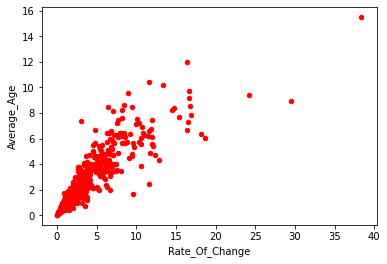

In [5]:
# Plot RTL_Change vs Average_Age
changeRate_df.plot.scatter(x='Rate_Of_Change', y='Average_Age', color='Red')

<AxesSubplot:xlabel='Rate_Of_Change', ylabel='Average_Age'>

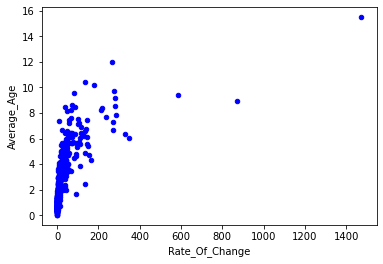

In [6]:
# Attempt Quadratic transformation on Rate_Of_Change
quad_df = changeRate_df.copy()
quad_df["Rate_Of_Change"] = changeRate_df["Rate_Of_Change"] * changeRate_df["Rate_Of_Change"]
quad_df.plot.scatter(x='Rate_Of_Change', y='Average_Age', color='Blue')

In [7]:
quad_df["Rate_Of_Change"].corr(quad_df["Average_Age"])

0.6378225831885936

<AxesSubplot:xlabel='Rate_Of_Change', ylabel='Average_Age'>

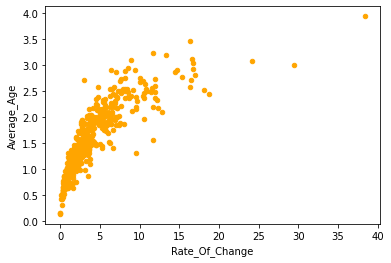

In [8]:
# Attempt Log Transformation on Rate_Of_Change
log_df = changeRate_df.copy()
log_df["Average_Age"] = np.sqrt((log_df["Average_Age"]))
log_df.plot.scatter(x='Rate_Of_Change', y='Average_Age', color='Orange')

In [9]:
log_df["Rate_Of_Change"].corr(log_df["Average_Age"])

0.8297577628771989

<AxesSubplot:xlabel='Rate_Of_Change', ylabel='Average_Age'>

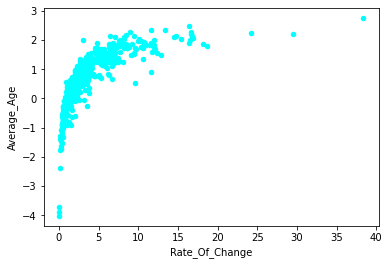

In [10]:
# Attempt Log Transformation on Average_Age
log_df = changeRate_df.copy()
log_df["Average_Age"] = np.log(changeRate_df["Average_Age"])
log_df.plot.scatter(x='Rate_Of_Change', y='Average_Age', color='Cyan')

<AxesSubplot:xlabel='Rate_Of_Change', ylabel='Average_Age'>

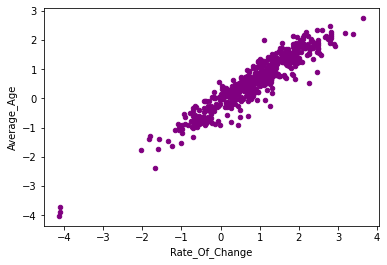

In [11]:
# Attempt Log Transformation on Average_Age and Rate_Of_Change
log_age_df = changeRate_df.copy()
log_age_df["Average_Age"] = np.log(changeRate_df["Average_Age"])
log_age_df["Rate_Of_Change"] = np.log(changeRate_df["Rate_Of_Change"])
log_age_df.plot.scatter(x='Rate_Of_Change', y='Average_Age', color='Purple')

In [12]:
log_age_df["Rate_Of_Change"].corr(log_age_df["Average_Age"])

0.9450535894488945

In [13]:
# Start processing on Rate of Change (Age/RTL)
plot_df = changeRate_df.copy()
plot_df

,Bird_ID,Average_Age,RTL_Change,Rate_Of_Change
0,5559.0,2.989954,0.08,3.996197
1,5539.0,1.310959,-0.25,3.267273
2,5536.0,2.325342,0.49,2.932903
3,5549.0,1.623288,0.12,3.530438
4,5509.0,0.821918,0.02,0.983247
...,...,...,...,...
556,5465.0,0.971233,-1.64,1.435086
557,5313.0,1.221918,0.04,1.952461
558,5529.0,1.638356,0.14,1.438498
559,5531.0,1.689041,0.03,1.961952


In [14]:
# Identify Rate of change to age correlation
changeRate_df["Rate_Of_Change"].corr(changeRate_df["Average_Age"])

0.8725830039135662

<AxesSubplot:>

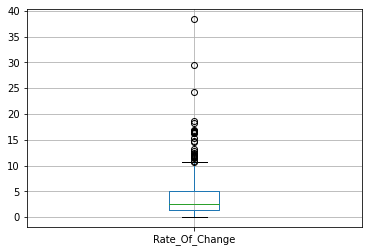

In [15]:
# Observe Stats of Change Rate
changeRate_df.boxplot("Rate_Of_Change")

In [16]:
# Remove Significant Outliers
changeRate_df = changeRate_df.loc[changeRate_df["Rate_Of_Change"] > -5]
changeRate_df = changeRate_df.loc[changeRate_df["Rate_Of_Change"] < 8.5]

<AxesSubplot:xlabel='Rate_Of_Change', ylabel='Average_Age'>

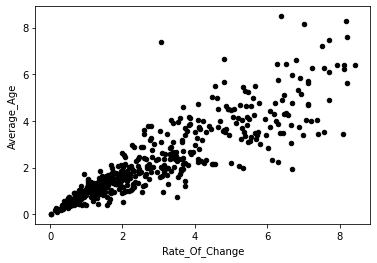

In [17]:
# Plot Age vs Rate of Change
changeRate_df.plot.scatter(x='Rate_Of_Change', y='Average_Age', color='Black')

In [18]:
# Initialize variables and Model
X = changeRate_df["Rate_Of_Change"].values.reshape(-1,1)
y = changeRate_df["Average_Age"]
model = LinearRegression()

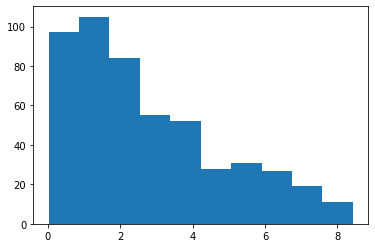

In [19]:
plt.hist(X)
plt.show()

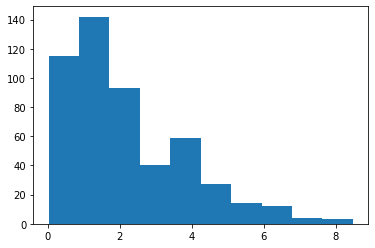

In [20]:
plt.hist(y)
plt.show()

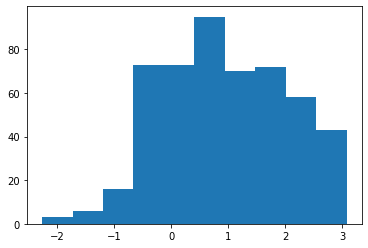

In [21]:
#Run a BoxCox transformation on the data -- see if regression is improved
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(changeRate_df["Rate_Of_Change"].values)
plt.hist(fitted_data)
plt.show()

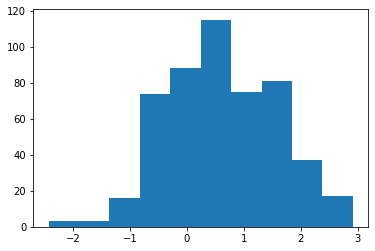

In [22]:
from scipy import stats
fitted_y, fitted_lambda = stats.boxcox(changeRate_df["Average_Age"])
plt.hist(fitted_y)
plt.show()

In [23]:
X = fitted_data.reshape(-1,1)
y = fitted_y

In [24]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1)
X_train.shape

(381, 1)

In [25]:
# Fit Model
model.fit(X_train, y_train)

LinearRegression()

In [26]:
# Make predictions and print the shape
y_pred = model.predict(X_test)
print(y_pred.shape)

(128,)


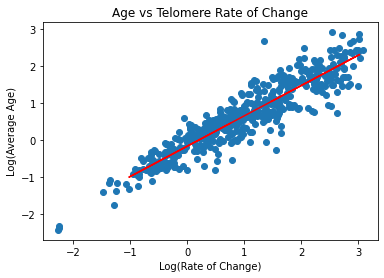

In [27]:
# Plot linear regression line
plt.scatter(X, y)
plt.plot(X_test, y_pred, color='red')
plt.xlabel("Log(Rate of Change)")
plt.ylabel("Log(Average Age)")
plt.title("Age vs Telomere Rate of Change")
plt.show()

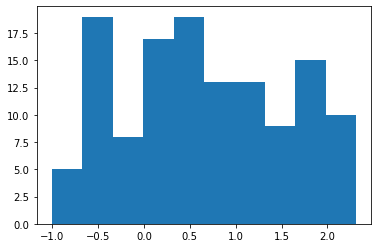

In [28]:
plt.hist(y_pred)
plt.show()

In [30]:
from mlxtend.evaluate import bias_variance_decomp

mse, bias, var = bias_variance_decomp(model, X_train, y_train, X_test, y_test, loss='mse', num_rounds=200, random_seed=1)
# summarize results
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.114
Bias: 0.114
Variance: 0.001


In [31]:
# model evaluation for testing set

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
MAE is 0.26789377305609885
MSE is 0.11357240613092948
R2 score is 0.8681742279327084


In [32]:
# Define the table creation function for Database Write -- Commented out as code was needed only once


# def create_table(curr, tablename):
#    create_table_command = ("""CREATE TABLE IF NOT EXISTS %s (
#                    BIRD_ID FLOAT NOT NULL PRIMARY KEY,
#                    Average_Age FLOAT NOT NULL,
#                    RTL_CHANGE FLOAT NOT NULL,
#                    RATE_OF_CHANGE FLOAT NOT NULL
#            )""")
 
#    curr.execute(create_table_command, [psycopg2.extensions.AsIs(tablename)])

In [37]:
# Re-establish connection to Database  -- Commented out as code was needed only once


# conn = psycopg2.connect(
#    database="Predictive_Senescence_DB", user='postgres', password= db_pw, host='predictive-senescence-db.cbunnafql9ym.us-east-2.rds.amazonaws.com', port= '5432'
# )

# #Setting auto commit false
# conn.autocommit = True

# #Creating a cursor object using the cursor() method
# cursor = conn.cursor()

# # Create a name for our table to pass to table creation function
# TABLE_NAME = "Megaphone_Data"

# # Creating new table in DB
# create_table(cursor, TABLE_NAME)

# # Define SQL execution command
# insert_into_table = ("""INSERT INTO Megaphone_Data (BIRD_ID, Average_Age, RTL_CHANGE, RATE_OF_CHANGE) VALUES(%s,%s,%s,%s);""")

# # Iterate through DF and execute commands to add data to table
# for i, row in changeRate_df.iterrows():
#    row_to_insert = (row["Bird_ID"], row["Average_Age"], row["RTL_Change"], row["Rate_Of_Change"])
#    cursor.execute(insert_into_table, row_to_insert)

# #Commit your changes in the database
# conn.commit()

# #Closing the connection
# conn.close()